
<br>
Example usage of DMF fMRI simulator.<br>
Pedro Mediano, June 2020<br>


In [1]:
import fastdyn_fic_dmf as dmf
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


Run simulation for a given nb of steps (milliseconds)

In [9]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['seed'] = 2
G_max = 15
LR_max = 15
#G_step = 0.1
#LR_step = 0.2
G_step = 5
LR_step = 10
G_range = np.arange(0,G_max,G_step)
LR_range = np.arange(0,LR_max,LR_step)
amount_slow_regions_grid = np.zeros((len(G_range), len(LR_range)))
mean_slow_grid = np.zeros((len(G_range), len(LR_range)))
std_slow_grid = np.zeros((len(G_range), len(LR_range)))
for idx_G,G in enumerate(G_range):
    for idx_LR,LR in enumerate(LR_range):
        params['G'] = G
        params['lrj'] = LR
        #params['taoj'] = 210000
        params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
        N = C.shape[0]
        tracemalloc.start()
        rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True)
        brunout = 5
        # Slicing and computations
        bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
        rates = rates[:, np.ceil(brunout * 1000).astype(int):]
        rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
        fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
        sampling_freq = 10000  
        power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
        plow_ptot = np.sum(power_spectrum[:, :39], axis=1)/np.sum(power_spectrum[:,:], axis=1)
        amount_slow_regions = np.sum(plow_ptot>0.3)
        mean_slow = np.mean(plow_ptot)
        std_slow = np.std(plow_ptot)
        amount_slow_regions_grid[idx_G, idx_LR] = amount_slow_regions
        mean_slow_grid[idx_G, idx_LR] = mean_slow
        std_slow_grid[idx_G, idx_LR] = std_slow

Calling run
Ending simulation    Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation    Using multitaper spectrum estimation with 30 DPSS windows
Calling run
Ending simulation    Using multitaper spectrum estimation with 30 DPSS windows


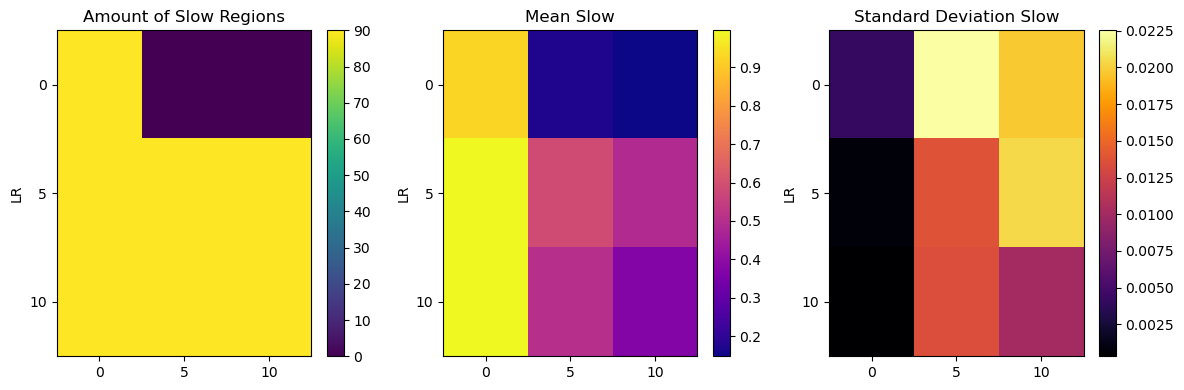

In [8]:
# Plotting the heatmap for amount_slow_regions
plt.figure(figsize=(12, 4))
# Plotting the heatmap for amount_slow_regions
plt.subplot(1, 3, 1)
plt.imshow(amount_slow_regions_grid, cmap='viridis', aspect='auto')
plt.title('Amount of Slow Regions')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.ylabel('LR')

# Plotting the heatmap for mean_slow
plt.subplot(1, 3, 2)
plt.imshow(mean_slow_grid, cmap='plasma', aspect='auto')
plt.title('Mean Slow')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.ylabel('LR')

# Plotting the heatmap for std_slow
plt.subplot(1, 3, 3)
plt.imshow(std_slow_grid, cmap='inferno', aspect='auto')
plt.title('Standard Deviation Slow')
plt.colorbar()
plt.xticks(ticks=range(len(LR_range)), labels=LR_range)
plt.yticks(ticks=range(len(G_range)), labels=G_range)
plt.ylabel('G')
plt.ylabel('LR')

plt.tight_layout()
plt.show()


In [89]:
plow_ptot = np.sum(power_spectrum[:, :39], axis=1)/np.sum(power_spectrum[:,:], axis=1)

In [78]:
brunout = 5
# Slicing and computations
bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

In [80]:
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc

(4005, 16)
(47, 90)
(31, 90)


In [81]:
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)

In [82]:

# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))


    Using multitaper spectrum estimation with 30 DPSS windows


Plotting

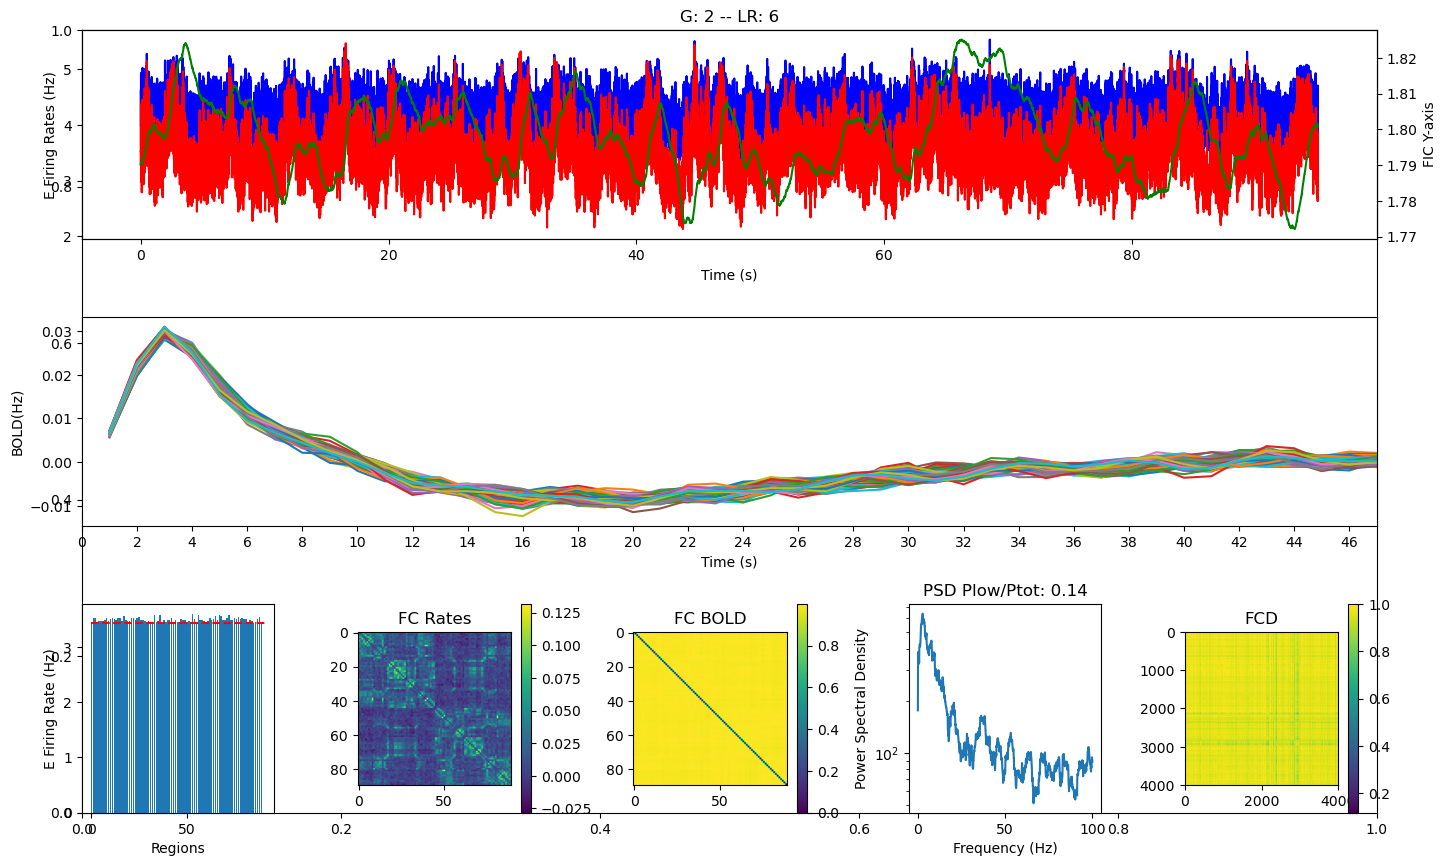

In [83]:
fig = plt.figure(figsize=(15, 9))
plt.title(f"G: {params['G']} -- LR: {params['lrj']}")
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.001, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.semilogy(frequencies, power_spectrum[0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[0, :39])/np.sum(power_spectrum[0,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()